# Knowledge Distillation
Using `LLaMA-3.2-1B-Instruct` to distill knowledge from `LLaMA-3.2-3B-Instruct` on a single prompt.

In [ ]:
# Install necessary packages
!pip install -q transformers accelerate torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from datasets import load_dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
from datasets import load_dataset
import random
import numpy as np
from torch.nn import CrossEntropyLoss, KLDivLoss
import matplotlib.pyplot as plt



os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_new_tokens = 256    


teacher_model_id = "meta-llama/Llama-3.2-3B-Instruct"
teacher_model = AutoModelForCausalLM.from_pretrained(
        teacher_model_id,
        torch_dtype=torch.float16,
        device_map=device,
)
   
    
teacher_model.eval() 
tokenizer = AutoTokenizer.from_pretrained(teacher_model_id)
    

In [ ]:
# Load models and tokenizer


device = 'cuda' if torch.cuda.is_available() else 'cpu'

student_model_id = "meta-llama/Llama-3.2-1B-Instruct"
student_model = AutoModelForCausalLM.from_pretrained(student_model_id).to(device).train()



In [ ]:
prompt = "How to learn a new language?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

teacher_output = tokenizer.decode(torch.argmax(teacher_model(input_ids).logits, dim=-1)[0])
student_output = tokenizer.decode(torch.argmax(student_model(input_ids).logits, dim=-1)[0])

print("Teacher:", teacher_output)
print("Student:", student_output)



Teacher: The to Choose a new language quickly (
Student: Tags to Choose a new language
 Tips


In [5]:
device = teacher_model.device  # or torch.device("cuda") if unsure

inputs = tokenizer("How to learn a new language?", return_tensors="pt", padding=True, truncation=True)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

teacher_gen = teacher_model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=200,
    pad_token_id=tokenizer.eos_token_id
)

student_gen = student_model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=200,
    pad_token_id=tokenizer.eos_token_id
)

teacher_output = tokenizer.decode(teacher_gen[0], skip_special_tokens=True)
student_output = tokenizer.decode(student_gen[0], skip_special_tokens=True)

print("Teacher:", teacher_output)
print("Student:", student_output)


Teacher: How to learn a new language? Learn a new language with the right mindset and strategies. Learning a new language can be a challenging but rewarding experience. Here are some tips to help you get started.
1. Set your goals: Before you start learning a new language, it's essential to set clear goals for yourself. What do you want to achieve in your language learning journey? Do you want to travel, communicate with family members, or improve your career prospects? Setting specific goals will help you stay motivated and focused.
2. Choose the right resources: There are many language learning resources available, including language learning apps, textbooks, and language exchange programs. Choose the resources that best fit your learning style and goals.
3. Practice consistently: Consistency is key when it comes to language learning. Set aside time each day to practice speaking, writing, listening, and reading in your target language.
4. Immerse yourself in the language: Surround yo

In [6]:
# Define prompt and encode
prompt = "How to learn a new language?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

In [ ]:

#wikitext-2 
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = [x['text'] for x in dataset if len(x['text'].strip()) > 30]  

#DataLoader
def collate_fn(batch_texts):
    enc = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    return {k: v.to(device) for k, v in enc.items()}

dataloader = DataLoader(texts, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [9]:
# Get teacher logits
with torch.no_grad():
    teacher_logits = teacher_model(**inputs).logits
print(teacher_logits.shape)  ###[1, 8, 128256]
print(teacher_logits)

torch.Size([1, 8, 128256])
tensor([[[ 1.9619,  2.1836,  7.7070,  ..., -1.3965, -1.3965, -1.3965],
         [ 2.3164, -0.1990,  1.2041,  ..., -5.7383, -5.7383, -5.7383],
         [ 2.7891,  1.9209,  1.1680,  ..., -5.4727, -5.4727, -5.4727],
         ...,
         [ 3.5410,  0.8315,  1.4443,  ..., -2.8652, -2.8652, -2.8652],
         [10.3594,  2.6738,  2.8320,  ..., -3.5234, -3.5234, -3.5234],
         [ 2.7246, -2.3945,  3.5566,  ..., -4.7383, -4.7383, -4.7383]]],
       device='cuda:0', dtype=torch.float16)


In [10]:
# Get student logits
student_logits = student_model(**inputs).logits
print(student_logits.shape)  ###[1, 8, 128256]
print(student_logits)

torch.Size([1, 8, 128256])
tensor([[[ 2.8333,  3.5810,  7.0268,  ..., -1.2470, -1.2469, -1.2468],
         [ 5.3712,  3.5411,  3.3081,  ..., -1.5862, -1.5862, -1.5861],
         [ 4.9956,  4.5364,  4.6009,  ..., -2.4338, -2.4354, -2.4351],
         ...,
         [ 5.0768,  5.1018,  4.1716,  ..., -0.5522, -0.5527, -0.5530],
         [12.2221,  6.5046,  5.8949,  ..., -1.8254, -1.8266, -1.8257],
         [ 6.4584,  2.6158,  7.0220,  ..., -2.9324, -2.9326, -2.9325]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)


In [ ]:


def evaluate_ppl(model, tokenizer, device="cuda:0"):
    test_dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    
    test_enc = tokenizer("\n\n".join(test_dataset["text"]), return_tensors="pt")
    model.seqlen = 2048
    test_enc = test_enc.input_ids.to(device)
    
    nsamples = test_enc.numel() // model.seqlen
    nlls = []  
    for i in tqdm(range(nsamples), desc="Evaluating..."):
        batch = test_enc[:, (i * model.seqlen):((i + 1) * model.seqlen)]
        
        with torch.no_grad():
            lm_logits = model(batch).logits

        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = test_enc[:, (i * model.seqlen):((i + 1) * model.seqlen)][:, 1:]

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * model.seqlen
        nlls.append(neg_log_likelihood)

    ppl = torch.exp(torch.stack(nlls).sum() / (nsamples * model.seqlen))
    
    return ppl.item()

def cal_ppl(model, model_name): 

    model.eval() 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    prompt = "How to learn a new language?"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    tputs = []
    time_record = []
    
    ppl = evaluate_ppl(model, tokenizer, device)
    print(f"Perplexity (PPL): {ppl}")

In [13]:
cal_ppl(teacher_model, "Jess437/Llama-3.2-3B-Instruct-gptq-b4g32")

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors
Evaluating...: 100%|██████████| 141/141 [00:42<00:00,  3.33it/s]

Perplexity (PPL): 11.49010181427002


In [ ]:
cal_ppl(student_model, "meta-llama/Llama-3.2-1B-Instruct")

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors
Evaluating...: 100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Perplexity (PPL): 13.160052299499512


In [ ]:

optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-6)
ce_loss_fn = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
kd_loss_fn = KLDivLoss(reduction="batchmean")

T = 1.0
kd_ratio = 0.5
max_steps = 500

total_list = []
ce_list = []
kd_list = []

for step, batch in enumerate(dataloader):
    if step >= max_steps:
        break

    input_ids = batch["input_ids"]
    attention_mask = batch.get("attention_mask", None)

    with torch.no_grad():
        teacher_logits = teacher_model(input_ids, attention_mask=attention_mask).logits.float()

    student_logits = student_model(input_ids, attention_mask=attention_mask).logits.float()

    # === Shift for CE & KD ===
    shift_student_logits = student_logits[:, :-1, :].contiguous()
    shift_teacher_logits = teacher_logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Cross-Entropy Loss
    ce_loss = ce_loss_fn(shift_student_logits.view(-1, shift_student_logits.size(-1)), shift_labels.view(-1))

    # Knowledge Distillation Loss (aligned)
    kd_s = F.log_softmax(shift_student_logits / T, dim=-1)
    kd_t = F.softmax(shift_teacher_logits / T, dim=-1)
    kd_loss = kd_loss_fn(kd_s.view(-1, kd_s.size(-1)), kd_t.view(-1, kd_t.size(-1))) * (T ** 2)

    # Loss
    loss = (1 - kd_ratio) * ce_loss + kd_ratio * kd_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_list.append(loss.item())
    ce_list.append(ce_loss.item())
    kd_list.append(kd_loss.item())

    print(f"Step {step}: total_loss = {loss.item():.4f} | ce = {ce_loss.item():.4f} | kd = {kd_loss.item():.4f}")


Step 0: total_loss = 1.8755 | ce = 3.1291 | kd = 0.6220
Step 1: total_loss = 2.2933 | ce = 3.8679 | kd = 0.7188
Step 2: total_loss = 3.1879 | ce = 4.3705 | kd = 2.0053
Step 3: total_loss = 1.9201 | ce = 3.1793 | kd = 0.6610
Step 4: total_loss = 1.7337 | ce = 2.9729 | kd = 0.4946
Step 5: total_loss = 1.7898 | ce = 2.9290 | kd = 0.6506
Step 6: total_loss = 1.8327 | ce = 3.1640 | kd = 0.5015
Step 7: total_loss = 1.8107 | ce = 3.1090 | kd = 0.5124
Step 8: total_loss = 1.6781 | ce = 2.9509 | kd = 0.4054
Step 9: total_loss = 2.1045 | ce = 3.5372 | kd = 0.6718
Step 10: total_loss = 2.0417 | ce = 3.5290 | kd = 0.5544
Step 11: total_loss = 2.2174 | ce = 3.6968 | kd = 0.7380
Step 12: total_loss = 1.7624 | ce = 3.0510 | kd = 0.4738
Step 13: total_loss = 2.0687 | ce = 3.5599 | kd = 0.5775
Step 14: total_loss = 1.9668 | ce = 3.3470 | kd = 0.5866
Step 15: total_loss = 1.8706 | ce = 3.2084 | kd = 0.5327
Step 16: total_loss = 1.9382 | ce = 3.4053 | kd = 0.4710
Step 17: total_loss = 1.6188 | ce = 2.829

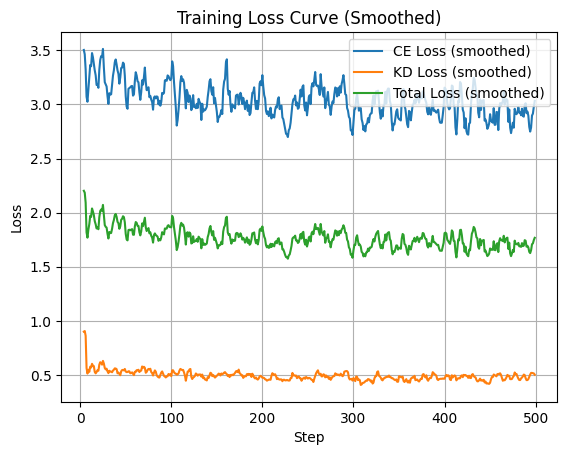

In [ ]:
# Draw Loss Curve
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 5

smooth_ce = moving_average(ce_list, window)
smooth_kd = moving_average(kd_list, window)
smooth_total = moving_average(total_list, window)

steps = list(range(window - 1, window - 1 + len(smooth_total)))

plt.plot(steps, smooth_ce, label="CE Loss (smoothed)")
plt.plot(steps, smooth_kd, label="KD Loss (smoothed)")
plt.plot(steps, smooth_total, label="Total Loss (smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve (Smoothed)")
plt.grid(True)

plt.savefig("training_loss_curve_smoothed.png", dpi=300, bbox_inches='tight')


plt.show()

In [18]:
student_model.save_pretrained("llama1B_finetuned")
tokenizer.save_pretrained("llama1B_finetuned")

('llama1B_finetuned/tokenizer_config.json',
 'llama1B_finetuned/special_tokens_map.json',
 'llama1B_finetuned/chat_template.jinja',
 'llama1B_finetuned/tokenizer.json')

In [19]:
prompt = "How to learn a new language?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

teacher_output = tokenizer.decode(torch.argmax(teacher_model(input_ids).logits, dim=-1)[0])
student_output = tokenizer.decode(torch.argmax(student_model(input_ids).logits, dim=-1)[0])

print("Teacher:", teacher_output)
print("Student:", student_output)


Teacher: The to Choose a new language quickly (
Student: The to write a new language
 



In [20]:

teacher_gen = teacher_model.generate(
    input_ids=input_ids,
    max_new_tokens=150,
    pad_token_id=tokenizer.eos_token_id
)

student_gen = student_model.generate(
    input_ids=input_ids,
    max_new_tokens=150,
    pad_token_id=tokenizer.eos_token_id
)

teacher_output = tokenizer.decode(teacher_gen[0], skip_special_tokens=True)
student_output = tokenizer.decode(student_gen[0], skip_special_tokens=True)

print("Teacher:", teacher_output)
print("Student:", student_output)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Teacher: How to learn a new language? (2022)
Learning a new language can be a challenging but rewarding experience. Here are some steps you can follow to learn a new language:
1. **Set your goals**: Define your motivation for learning the language, and set specific, achievable goals. Are you traveling, working, or studying abroad? Do you want to improve your career prospects or connect with family and friends?
2. **Choose your resources**: There are many language learning resources available, including:
	* Language learning apps like Duolingo, Babbel, and Rosetta Stone
	* Language exchange websites like italki and Conversation Exchange
	* Language courses at local colleges or language schools
	* Language learning books and podcasts
	* Language learning YouTube channels and
Student: How to learn a new language? The best way to learn a new language is through a combination of several methods. Here are some of the most effective ways to learn a new language:

1. **Immerse yourself in the 

In [21]:
cal_ppl(student_model, "llama1B_finetuned/")

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors
Evaluating...: 100%|██████████| 141/141 [00:48<00:00,  2.94it/s]


Perplexity (PPL): 11.716170310974121
